In [1]:
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


In [2]:
stroke = pd.read_csv("../../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

In [4]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked


In [5]:
y

array([1, 1, 1, ..., 0, 0, 0], shape=(5110,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [7]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
X.shape

(5110, 10)

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor_with_imputation),
    ('undersampler', NearMiss()),
    ('oversampler', BorderlineSMOTE(random_state=0)),
    ('pca', PCA(random_state=0)),
    ('nn_classifier', MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=20, random_state=0)),
])

voglio una metrica che dia piu peso ai veri positivi considerando però anche i veri negativi

In [10]:
def custom_weighted_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y_true, y_pred)

    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    tn = cm[0, 0]

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Pesi: recall molto alto, specificity alto, penalità forti per FN e FP
    weighted_score = (
        0.8 * recall +           # Altissimo peso ai veri positivi
        0.7 * specificity -     # Peso importante ai veri negativi
        0.4 * (fn / (tp + fn) if (tp + fn) > 0 else 0.0) -  # Penalità fortissima per FN
        0.1 * (fp / (tn + fp) if (tn + fp) > 0 else 0.0)    # Penalità moderata per FP
    )
    return weighted_score


{'undersampler__sampling_strategy': 0.25,
 'undersampler': RandomUnderSampler(random_state=0),
 'pca__n_components': None,
 'oversampler__sampling_strategy': 1.0,
 'oversampler__n_neighbors': 5,
 'oversampler': ADASYN(random_state=0),
 'nn_classifier__solver': 'adam',
 'nn_classifier__n_iter_no_change': 50,
 'nn_classifier__learning_rate_init': 0.0005,
 'nn_classifier__hidden_layer_sizes': (100, 50, 25),
 'nn_classifier__alpha': 0.1,
 'nn_classifier__activation': 'logistic'}

In [11]:
param_distributions = [
    {
        'undersampler': [RandomUnderSampler(random_state=0), NearMiss()],
        'undersampler__sampling_strategy': [0.1, 0.15, 0.2, 0.25, 0.3],
        'oversampler': [ADASYN(random_state=0)], #  BorderlineSMOTE(random_state=0)
        'oversampler__sampling_strategy': ['auto', 0.9, 1.0],
        'oversampler__n_neighbors': [3, 4, 5, 7],
        'pca__n_components': [None, 5, 6, 7, 8, 10],
        'nn_classifier__hidden_layer_sizes': [
            (80, 40, 20), (100, 50, 25), (120, 60, 30)
        ],
        'nn_classifier__activation': ['relu', 'tanh', 'logistic'],
        'nn_classifier__alpha': [0.01, 0.05, 0.1, 0.15, 0.2],
        'nn_classifier__learning_rate_init': [0.00005, 0.0001, 0.0003, 0.0005, 0.001],
        'nn_classifier__solver': ['adam', 'sgd'],
        'nn_classifier__n_iter_no_change': [20, 30, 40, 50]
    }
]

In [12]:
# n_iter=500, random_state=0

random_search = RandomizedSearchCV(pipeline, param_distributions,  cv=3, scoring=custom_weighted_scorer, verbose=1, n_jobs=-1, n_iter=500, random_state=0)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index(['...
                                         'oversampler': [ADASYN(random_state=0)],
                                         'oversampler__n_neighbors': [3, 4, 5,
                                                                      7],
                                         'oversampler__sampling_strategy': ['auto',
                                                                            0.9,
                                                                            1.0],
                                         'pca__n_components': [None, 5, 6, 7, 8,
                                                               10],
                                         'undersampler': [RandomUnderSampler(random_state=0),
                                                          NearMiss()],
                                         'undersampler__sampling_strategy': [0.1,
                                                                             0.15,
                                                                             0.2,
                                                                             0.25,
                                                                             0.3]}],
                   random_state=0,
                   scoring=<function custom_weighted_scorer at 0x000001683214B060>,
                   verbose=1)

In [13]:
random_search.best_params_

{'undersampler__sampling_strategy': 0.15,
 'undersampler': RandomUnderSampler(random_state=0),
 'pca__n_components': 10,
 'oversampler__sampling_strategy': 1.0,
 'oversampler__n_neighbors': 7,
 'oversampler': ADASYN(random_state=0),
 'nn_classifier__solver': 'sgd',
 'nn_classifier__n_iter_no_change': 40,
 'nn_classifier__learning_rate_init': 0.0003,
 'nn_classifier__hidden_layer_sizes': (100, 50, 25),
 'nn_classifier__alpha': 0.15,
 'nn_classifier__activation': 'tanh'}

In [14]:
random_search.best_score_

np.float64(1.1069675887883517)

In [15]:
def create_confusion_matrix (random_search, X, y):
  best_model = random_search.best_estimator_
  y_pred = best_model.predict(X)

  print("\n--- Confusion Matrix ---")
  cm = confusion_matrix(y, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

  print(f"Precisione (soglia default): {precision_score(y, y_pred, zero_division=0):.4f}")
  print(f"Recall (soglia default): {recall_score(y, y_pred, zero_division=0):.4f}")
  print(f"F1-Score (soglia default): {f1_score(y, y_pred, zero_division=0):.4f}")


--- Confusion Matrix ---


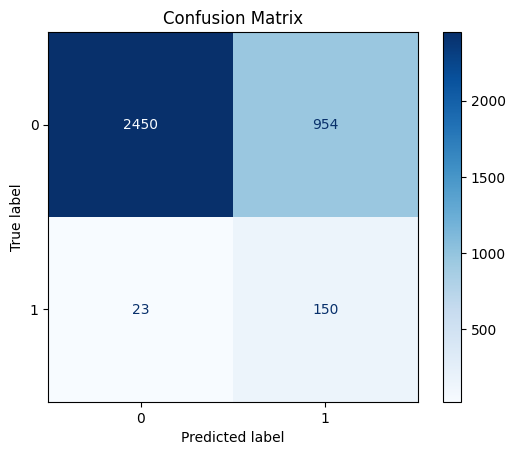

Precisione (soglia default): 0.1359
Recall (soglia default): 0.8671
F1-Score (soglia default): 0.2349


In [16]:
create_confusion_matrix(random_search, X_train, y_train)


--- Confusion Matrix ---


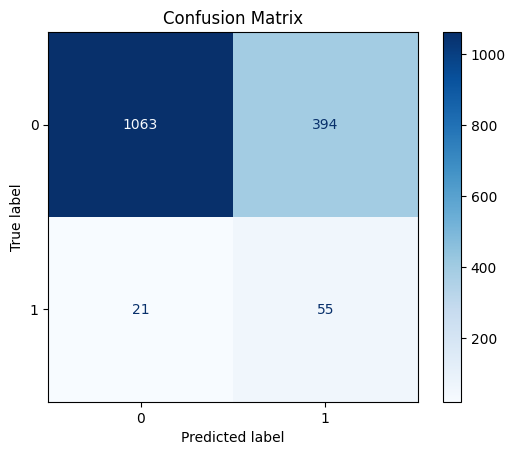

Precisione (soglia default): 0.1225
Recall (soglia default): 0.7237
F1-Score (soglia default): 0.2095


In [17]:
create_confusion_matrix(random_search, X_test, y_test)